In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage


COLOR = 'green'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Load data
df = pd.read_csv('UsArrests.csv')
df.head()


,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


### Data exploration

In [13]:
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


Here we can see that the standard deviation for assaults is far greater than for the other variables, therefore we will scale the data later on so as to avoid skew

### PCA

#### Generate heatmap

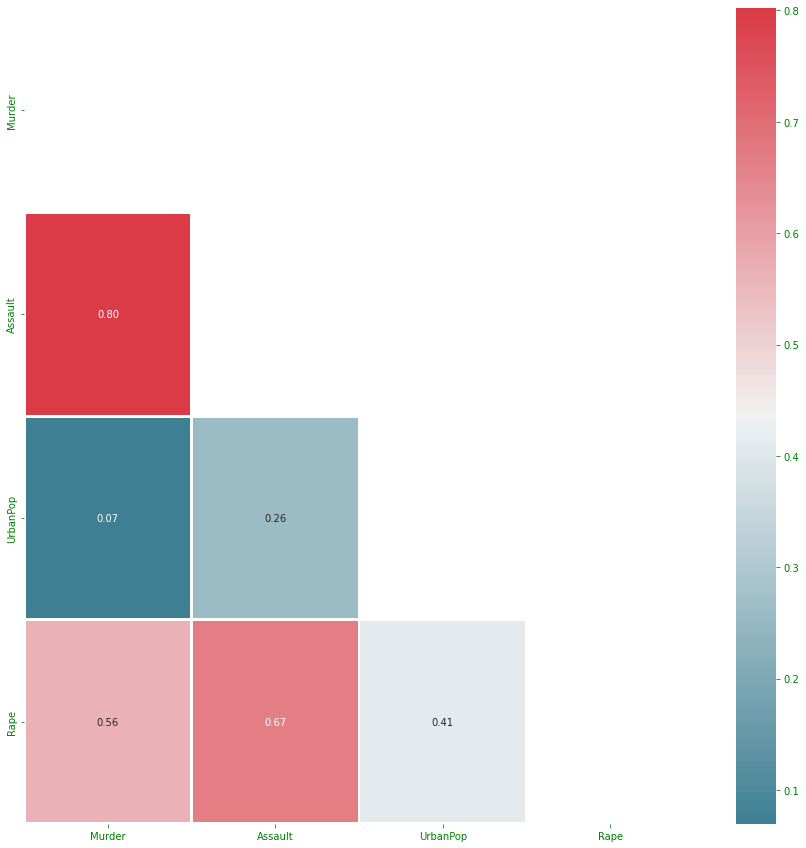

In [14]:
colormap = sns.diverging_palette(220, 10, as_cmap=True)
# get correlations
corrs = df.corr()

# Plot figsize
fig, ax = plt.subplots(figsize=(15, 15))

# to mask mirrored side of heatmap
dropSelf = np.zeros_like(corrs)
dropSelf[np.triu_indices_from(dropSelf)] = True

# Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)

plt.show()

#### Apply PCA

In [15]:
# select and standardize features
# The reason we want to scale the features here is because 
# there is a significant difference 
X = StandardScaler().fit_transform(df.iloc[:, 1:].values)

# choose number of components to be generated
nr_comps = 3
pca = PCA(n_components=nr_comps)

# obtain components
principal_components = pca.fit_transform(X)

# transform the components into a pandas data frame
# Use the city as index
pca_df = pd.DataFrame(principal_components, index=df['City'])
pca_df.head()

,0,1,2
City,,,
Alabama,0.985566,1.133392,-0.444269
Alaska,1.950138,1.073213,2.040003
Arizona,1.763164,-0.745957,0.054781
Arkansas,-0.141420,1.119797,0.114574
California,2.523980,-1.542934,0.598557


#### Access corrs between component variables and original variables


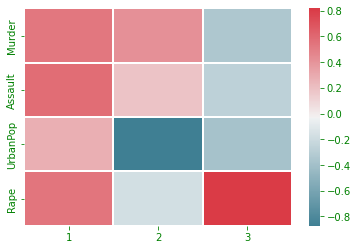

In [16]:
# Look at component and original variable corrolations
components = pd.DataFrame(pca.components_, columns=df.iloc[:, 1:].columns, index=range(1, nr_comps+1)).transpose()
ax = sns.heatmap(components,cmap=colormap,linewidth=1)
plt.show()

Given the similarity between the two in the above heatmap, it is likely that either assault or murder has been removed in order to reduce dimensionality 

### K-means clustering

#### Plot scatter graphs of the 3 variables to identify best clustering candidate

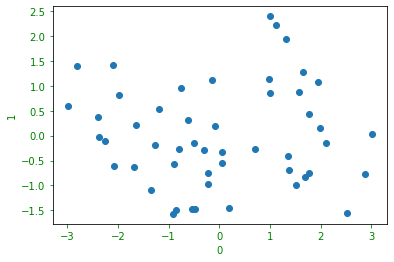

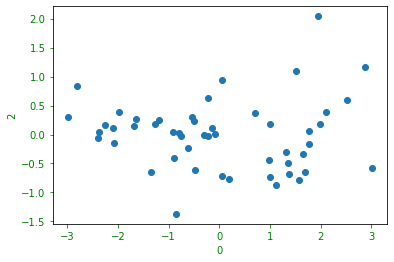

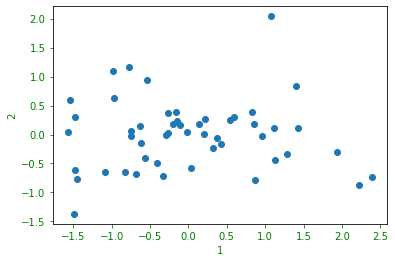

In [17]:

variables = pca_df.columns
# Create scatter plots with different variable combinations
for i in range(4):
    for j in range(i+1, 3):
        # Get variables for plotting
        var_1 = variables[i]
        var_2 = variables[j]
        
        # Plot scatter graphs
        plt.scatter(pca_df[var_1], pca_df[var_2])
        plt.xlabel(var_1)
        plt.ylabel(var_2)
        plt.show()

Plotting variables 1 and 0 results in a fairly dispersed scatter graph. The other two combinations are somewhat less dispersed, but neither are particularly ideal candidates. The graph for 2 and 0 seemingly shows some somewhat distinct clusters, so we will perform K-means between these two variables. 

##### Perform K-means with a range of values for K to determine which is the optimal amount of clusters

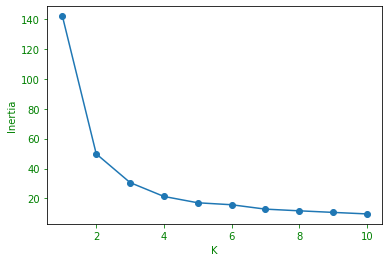

In [18]:
# Select variables
X = pca_df[[0, 2]].values

# Function that returns interia for kmeans plotted with K
def eval_Kmeans(x, k, r):
    # Initialise model
    kmeans = KMeans(n_clusters=k, random_state=r, n_init='auto')
    
    # Fit to data 
    kmeans.fit(x)    
    return kmeans.inertia_

# Plot elbow graph
def elbow_Kmeans(x, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1,max_k+1)]
    plt.plot(range(1,11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

elbow_Kmeans(X)


This elbow plot implies that the optimal number of clusters is 2

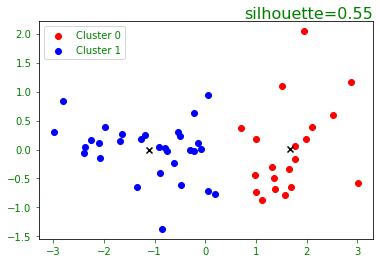

In [19]:
k = 2

# Initalise model with k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=123, n_init='auto')
# Fit and predict clusters
y_pred = kmeans.fit_predict(X)

# Colours for clusters 
colours = 'rbgcmy'
for c in range(k):
    # Plot clusters 
    plt.scatter(X[y_pred == c, 0], X[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
    # Plot cluster centers
    plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')

# Calculate score for model
score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'),2)
plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)

plt.legend()
plt.show()


Clusters have been identified with a reasonable silhouette score

### Hierarchical clustering

We will perform heriarchical clustering using the same two variables as above

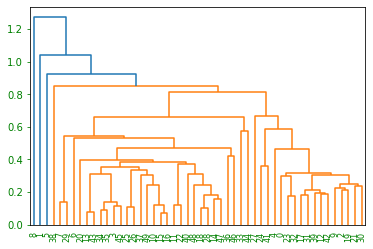

In [22]:
X = pca_df[[0, 2]]
 
methods = ['single', 'complete']
metrics = ['euclidean', 'cityblock']

# Compare clustering techniques by displaying 4 different dendrograms
dend = dendrogram(linkage(X, method='single', metric='euclidean')) 

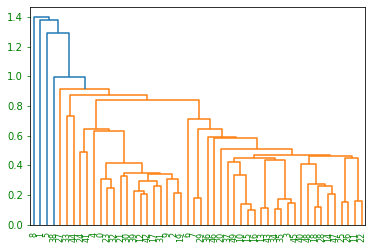

In [23]:
dend = dendrogram(linkage(X, method='single', metric='cityblock')) 

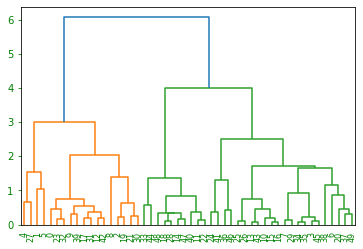

In [24]:
dend = dendrogram(linkage(X, method='complete', metric='euclidean'))

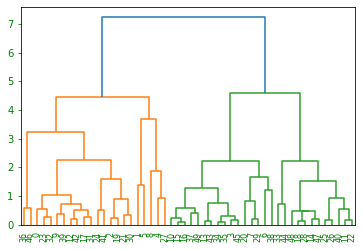

In [25]:
dend = dendrogram(linkage(X, method='complete', metric='cityblock'))

The latter two are more informative dendrograms so will use one of the metrics with the complete method

Text(0.5, 1.0, 'silhouette_score = 0.5')

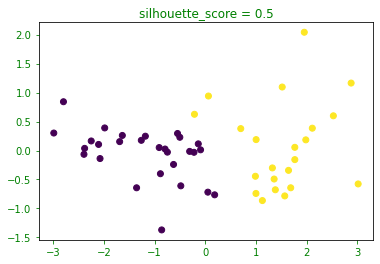

In [29]:
# Perform agglomerative clustering
cluster = AgglomerativeClustering(
    n_clusters=2, 
    metric='cityblock', 
    linkage="complete"
)
cluster.fit_predict(X)

#Plot clusters
plt.scatter(X[0], X[2], c=cluster.labels_)

score = round(silhouette_score(X, cluster.labels_, metric='cityblock'),2)
plt.title(label=f"silhouette_score = {score}")


As with K-means, we have a relatively high silhouette score and logical clusters

In [44]:
# Add cluster label to orginal df
df['Cluster'] = cluster.labels_

# Examine statistics for each cluster
df.loc[df['Cluster'] == 1].describe()

,Murder,Assault,UrbanPop,Rape,Cluster
count,22.000000,22.000000,22.000000,22.000000,22.0
mean,11.463636,245.863636,68.545455,29.036364,1.0
std,3.419767,51.851707,13.796919,8.002294,0.0
min,4.000000,145.000000,44.000000,16.100000,1.0
25%,9.250000,205.750000,59.250000,24.375000,1.0
50%,11.750000,253.000000,70.000000,27.350000,1.0
75%,13.200000,278.250000,80.000000,32.050000,1.0
max,17.400000,337.000000,91.000000,46.000000,1.0


In [45]:
df.loc[df['Cluster'] == 0].describe()

,Murder,Assault,UrbanPop,Rape,Cluster
count,28.000000,28.000000,28.000000,28.000000,28.0
mean,4.900000,111.750000,63.178571,15.100000,0.0
std,2.382032,48.019768,14.800034,4.558834,0.0
min,0.800000,45.000000,32.000000,7.300000,0.0
25%,2.675000,78.750000,52.750000,11.175000,0.0
50%,4.850000,109.500000,64.000000,15.700000,0.0
75%,6.650000,149.500000,72.750000,18.975000,0.0
max,9.700000,238.000000,89.000000,22.900000,0.0


One thing that stands out from cluster 1 versus cluster 2 is that the mean count for each crime is lower. The urban population is also lower but this is not a directly influencing factor as the crimes are expressed a crimerate per 100 people.

In [49]:
# Lets print out the cities in each cluster
print(df.loc[df['Cluster'] == 0]['City'])

3          Arkansas
6       Connecticut
7          Delaware
10           Hawaii
11            Idaho
13          Indiana
14             Iowa
15           Kansas
16         Kentucky
18            Maine
20    Massachusetts
22        Minnesota
25          Montana
26         Nebraska
28    New Hampshire
29       New Jersey
33     North Dakota
34             Ohio
35         Oklahoma
37     Pennsylvania
38     Rhode Island
40     South Dakota
43             Utah
44          Vermont
45         Virginia
47    West Virginia
48        Wisconsin
49          Wyoming
Name: City, dtype: object


In [50]:
print(df.loc[df['Cluster'] == 1]['City'])

0            Alabama
1             Alaska
2            Arizona
4         California
5           Colorado
8            Florida
9            Georgia
12          Illinois
17         Louisiana
19          Maryland
21          Michigan
23       Mississippi
24          Missouri
27            Nevada
30        New Mexico
31          New York
32    North Carolina
36            Oregon
39    South Carolina
41         Tennessee
42             Texas
46        Washington
Name: City, dtype: object


It is possible that there is a socio-geographical element that can explain the cities in each cluster, but without extra data it is impossible to draw any concrete conclusions that aren't speculation